# Fitting logarithmic spirals to HMSFR data

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from galpy.potential import evaluatePotentials, evaluateDensities, plotPotentials, MWPotential2014, SpiralArmsPotential
from galpy.util import bovy_coords

//anaconda/envs/galpy/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)



In [2]:
tbl = ascii.read('../data/asu.tsv', data_start=2)
arm_ids = np.unique(tbl['Arm'])
listof_hmsfr = []
listof_dist_err = []

for k in range(len(arm_ids)):
    selector = (tbl['Arm'] == arm_ids[k])
    listof_hmsfr.append(SkyCoord(ra=tbl['RAJ2000'][selector], dec=tbl['DEJ2000'][selector], distance=1/tbl['plx'][selector]
             ,unit=['hourangle', 'deg', 'kpc'], equinox='J2000.0'))
    listof_dist_err.append((tbl['e_plx'][selector] / tbl['plx'][selector] / tbl['plx'][selector]) * u.kpc)
    
# Convert to galactocentric coordinates
for k in range(len(listof_hmsfr)):
    listof_hmsfr[k] = listof_hmsfr[k].transform_to(coord.Galactocentric(galcen_distance=8.34*u.kpc))

In [3]:
def plt_hmsfr(fig, ax, extent):
    markers = ['^', 'o', 'd', 'X', '*', 'p', 'h', 's', 'H']

    for k in range(len(listof_hmsfr)):
        ax.scatter(listof_hmsfr[k].x, -listof_hmsfr[k].y,
                    marker=markers[k], label=arm_ids[k])
        ax.errorbar(listof_hmsfr[k].x.value, -listof_hmsfr[k].y.value, yerr=listof_dist_err[k].value, fmt=None)
        
    ax.scatter(0, 0, marker=(6, 2, 0), color='r', s=400)  # center of Milky Way
    ax.scatter(-8.34, 0, marker='o', color='y', s=200)  # the sun

    ax.set_xlim((extent[0], extent[1]))
    ax.set_ylim((extent[2], extent[3]))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    #ax.grid(b=True, which='major', color='k', linestyle='--')
    plt.legend()
    plt.xlabel('x (kpc)')
    plt.ylabel('y (kpc)')

In [4]:
def plt_spirals(fig, ax, pot, x, y, extent, cmap='Greys', plotlog=False):
    n = len(x)
    X, Y = np.meshgrid(x, y)
    potxy = np.zeros((n, n))

    for ii in range(n):
        for jj in range(n):
            R, phi, z = bovy_coords.rect_to_cyl(x[ii].value, y[jj].value, 0)
            potxy[ii, jj] = evaluateDensities(pot, R*u.kpc, z*u.kpc, phi)

    if plotlog:
        c = ax.contourf(np.log(potxy.T), origin='lower', extent=extent, ncontours=21, cmap=cmap, alpha=0.3)
    else:
        c = ax.contourf(potxy.T, origin='lower', extent=extent, ncontours=21, cmap=cmap, alpha=0.3)
        
    ax.set_xlabel('x (kpc)')
    ax.set_ylabel('y (kpc)')
    ax.set_title('Density')

In [5]:
def plt_hmsfr_and_spirals(pot, cmap='Greys', plotlog=False):
    fig, ax = plt.subplots(figsize=(10,10))

    x = np.linspace(-17, 17, 100) * u.kpc
    y = np.linspace(-17, 17, 100) * u.kpc

    extent = [-17, 17, -17, 17]

    plt_spirals(fig, ax, pot, x, y, extent, cmap, plotlog=plotlog)

    plt_hmsfr(fig, ax, extent)

    plt.gca().invert_yaxis()
    plt.show()

## Averaging parameters for all 5 arms (Scutum, Sagittarius, Local, Perseus, Outer)

In [6]:
N = np.array([17., 18., 25., 24., 6.])  # number of parallax measurements for HMSFR in each arm

phi_ref = np.array([27.6, 25.6, 8.9, 14.2, 18.6])  # Galactocentric azimuth in degrees
phi_ref_err = np.array([101-3, 68+2, 27+8, 88+21, 56+6])

r_ref = np.array([5., 6.6, 8.4, 9.9, 13.])  # kpc
r_ref_err = np.array([0.1, 0.1, 0.1, 0.1, 0.3])

width = np.array([0.17, 0.26, 0.33, 0.38, 0.63])  # kpc
width_err = np.array([0.02, 0.02, 0.01, 0.01, 0.18])

alpha = np.array([19.8, 6.9, 12.8, 9.4, 13.8])  # pitch angle, degrees
alpha_err = np.array([2.6, 1.6, 2.7, 1.4, 3.3])

phi_ref_avg = np.average(phi_ref, weights=N/phi_ref_err**2)
r_ref_avg = np.average(r_ref, weights=N/r_ref_err**2)
width_avg = np.average(width, weights=N/width_err**2)
alpha_avg = np.average(alpha, weights=N/alpha_err**2)

In [7]:
phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(12.987108757250061,
 7.796062992125985,
 0.33364481487417857,
 10.279265167731866)

//anaconda/envs/galpy/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)

//anaconda/envs/galpy/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

//anaconda/envs/galpy/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):



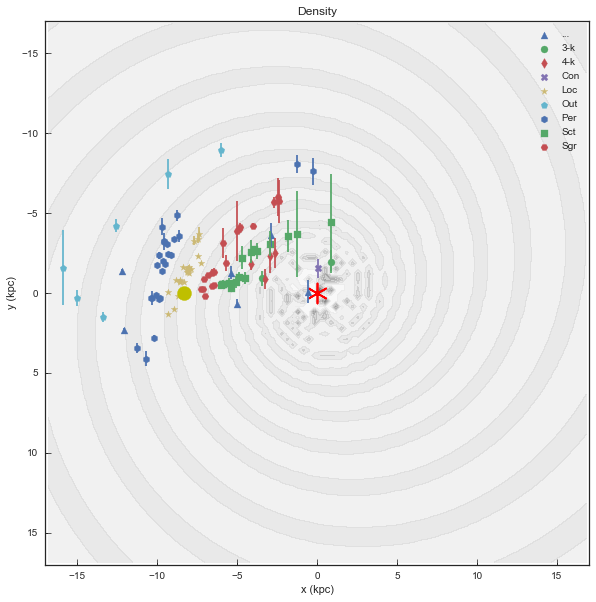

In [8]:
sp = SpiralArmsPotential(amp=1, N=5, alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
plt_hmsfr_and_spirals(sp);

## Averaging parameters for Scutum, Sagittarius, Local, Perseus only

In [9]:
selector = [0, 1, 2, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=N[selector]/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=N[selector]/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=N[selector]/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=N[selector]/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(12.672775669828583,
 7.7547619047619047,
 0.33354978354978354,
 10.202350971526366)

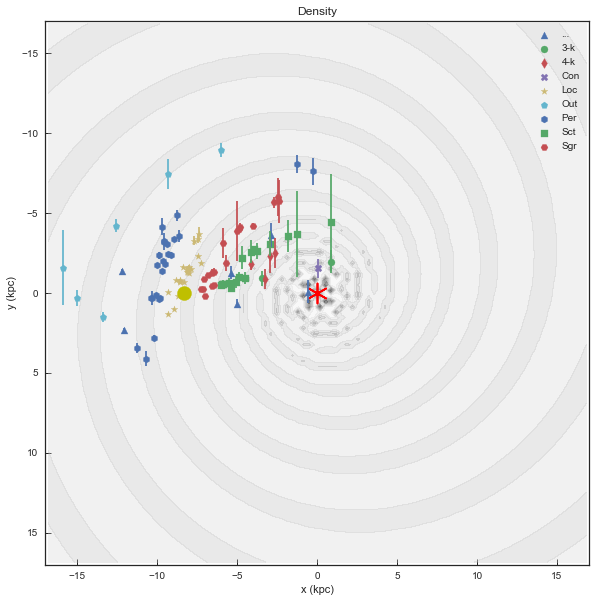

In [10]:
sp = SpiralArmsPotential(amp=1, N=len(selector), alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
plt_hmsfr_and_spirals(sp);

## Averaging parameters for Scutum, Sagittarius, Perseus only

In [11]:
selector = [0, 1, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=N[selector]/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=N[selector]/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=N[selector]/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=N[selector]/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(22.988903420419657,
 7.4813559322033898,
 0.33625954198473285,
 9.7935452447646316)

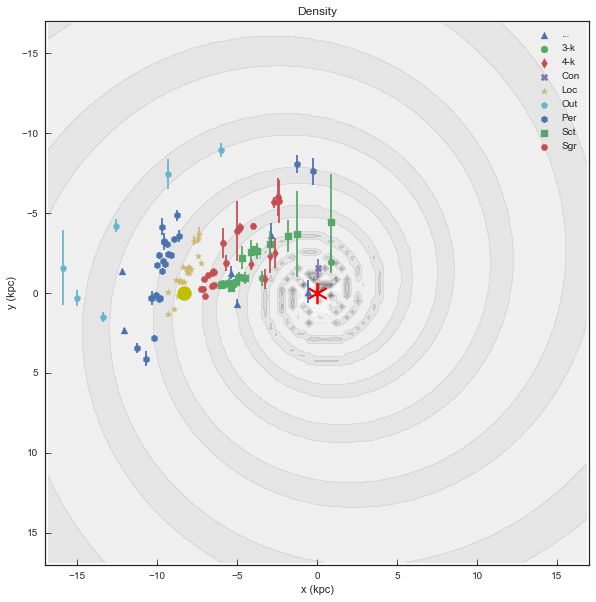

In [12]:
sp = SpiralArmsPotential(amp=1, N=len(selector), alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
plt_hmsfr_and_spirals(sp);

## Averaging parameters for Scutum, Sagittarius, Perseus only and adding a single local arm

In [13]:
selector = [0, 1, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=N[selector]/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=N[selector]/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=N[selector]/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=N[selector]/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(22.988903420419657,
 7.4813559322033898,
 0.33625954198473285,
 9.7935452447646316)

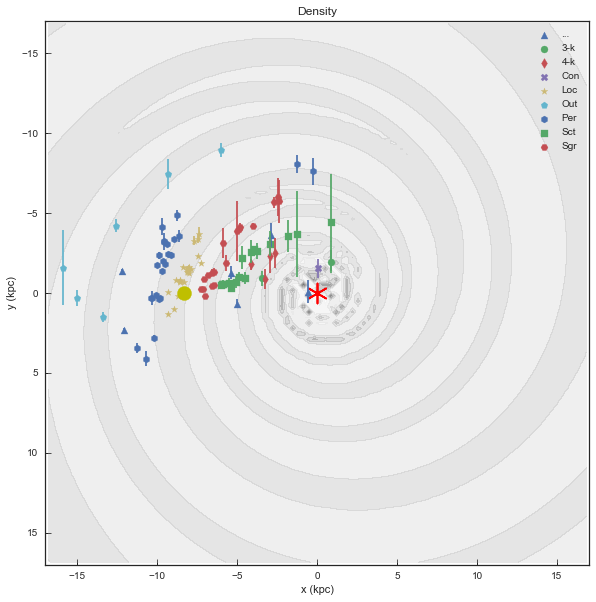

In [14]:
sp = SpiralArmsPotential(amp=1, N=len(selector), alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
sp = [sp] + [SpiralArmsPotential(amp=0.3, N=2, alpha=12.8*u.deg, phi_ref=(8.9)*u.deg, r_ref=8.4*u.kpc, H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])]
plt_hmsfr_and_spirals(sp);

In [15]:
selector = [0, 1, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=N[selector]/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=N[selector]/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=N[selector]/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=N[selector]/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(22.988903420419657,
 7.4813559322033898,
 0.33625954198473285,
 9.7935452447646316)

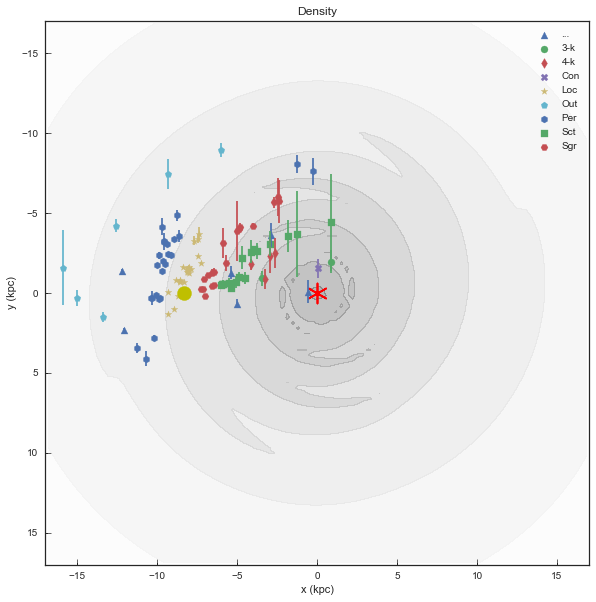

In [27]:
sp = [SpiralArmsPotential(amp=2, N=len(selector), alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])] + MWPotential2014
plt_hmsfr_and_spirals(sp, plotlog=True);

# Trying different weights; sqrt(N) / err^2

## Averaging parameters for all 5 arms (Scutum, Sagittarius, Local, Perseus, Outer)

In [17]:
N = np.array([17., 18., 25., 24., 6.])  # number of parallax measurements for HMSFR in each arm

phi_ref = np.array([27.6, 25.6, 8.9, 14.2, 18.6])  # Galactocentric azimuth in degrees
phi_ref_err = np.array([101-3, 68+2, 27+8, 88+21, 56+6])

r_ref = np.array([5., 6.6, 8.4, 9.9, 13.])  # kpc
r_ref_err = np.array([0.1, 0.1, 0.1, 0.1, 0.3])

width = np.array([0.17, 0.26, 0.33, 0.38, 0.63])  # kpc
width_err = np.array([0.02, 0.02, 0.01, 0.01, 0.18])

alpha = np.array([19.8, 6.9, 12.8, 9.4, 13.8])  # pitch angle, degrees
alpha_err = np.array([2.6, 1.6, 2.7, 1.4, 3.3])

phi_ref_avg = np.average(phi_ref, weights=np.sqrt(N)/phi_ref_err**2)
r_ref_avg = np.average(r_ref, weights=np.sqrt(N)/r_ref_err**2)
width_avg = np.average(width, weights=np.sqrt(N)/width_err**2)
alpha_avg = np.average(alpha, weights=np.sqrt(N)/alpha_err**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(13.70120025699363,
 7.6957351110068402,
 0.33067066171339538,
 10.372558482136515)

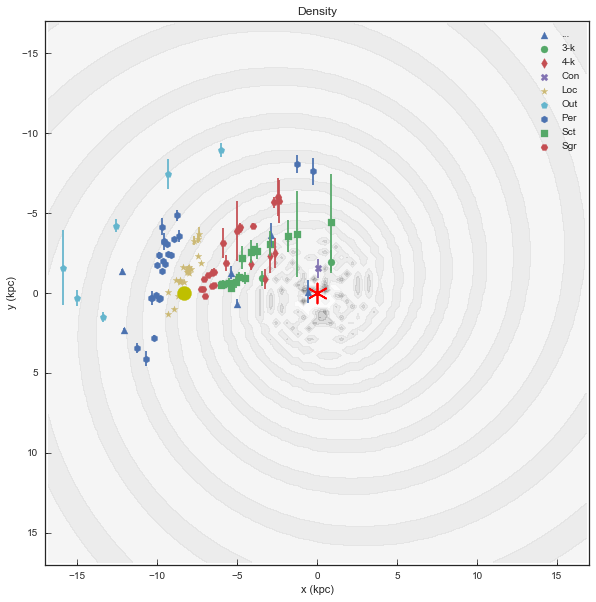

In [18]:
sp = SpiralArmsPotential(amp=1, N=5, alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
plt_hmsfr_and_spirals(sp);

## Averaging parameters for Scutum, Sagittarius, Local, Perseus only

In [19]:
selector = [0, 1, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=np.sqrt(N[selector])/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=np.sqrt(N[selector])/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=np.sqrt(N[selector])/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=np.sqrt(N[selector])/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(23.349905125951256,
 7.3214369484067889,
 0.3308266370951779,
 9.8615438978457686)

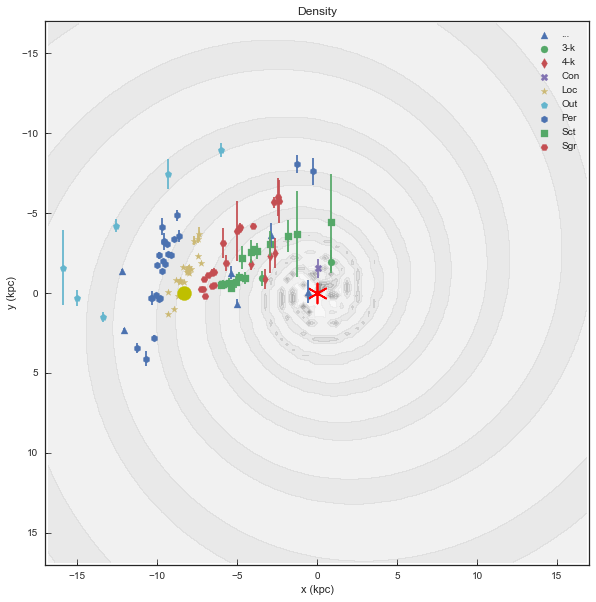

In [20]:
sp = SpiralArmsPotential(amp=1, N=len(selector), alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
plt_hmsfr_and_spirals(sp);

## Averaging parameters for Scutum, Sagittarius, Perseus only

In [21]:
selector = [0, 1, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=np.sqrt(N[selector])/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=np.sqrt(N[selector])/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=np.sqrt(N[selector])/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=np.sqrt(N[selector])/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(23.349905125951256,
 7.3214369484067889,
 0.3308266370951779,
 9.8615438978457686)

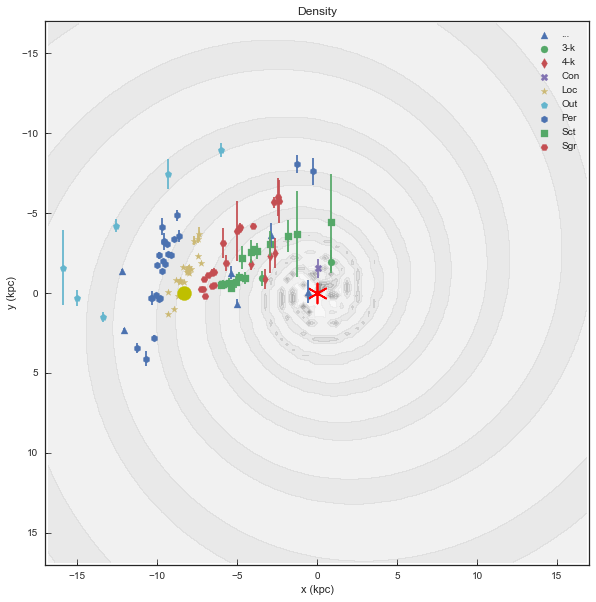

In [22]:
sp = SpiralArmsPotential(amp=1, N=len(selector), alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[8./3./np.pi, 0.5, 8./15./np.pi])
plt_hmsfr_and_spirals(sp);

## Averaging parameters for Sagittarius and Perseus only

In [23]:
selector = [1, 3]
phi_ref_avg = np.average(phi_ref[selector], weights=np.sqrt(N[selector])/phi_ref_err[selector]**2)
r_ref_avg = np.average(r_ref[selector], weights=np.sqrt(N[selector])/r_ref_err[selector]**2)
width_avg = np.average(width[selector], weights=np.sqrt(N[selector])/width_err[selector]**2)
alpha_avg = np.average(alpha[selector], weights=np.sqrt(N[selector])/alpha_err[selector]**2)

phi_ref_avg, r_ref_avg, width_avg, alpha_avg

(21.922398537881641,
 8.3684646700454088,
 0.3586431348317029,
 8.4032614461736195)

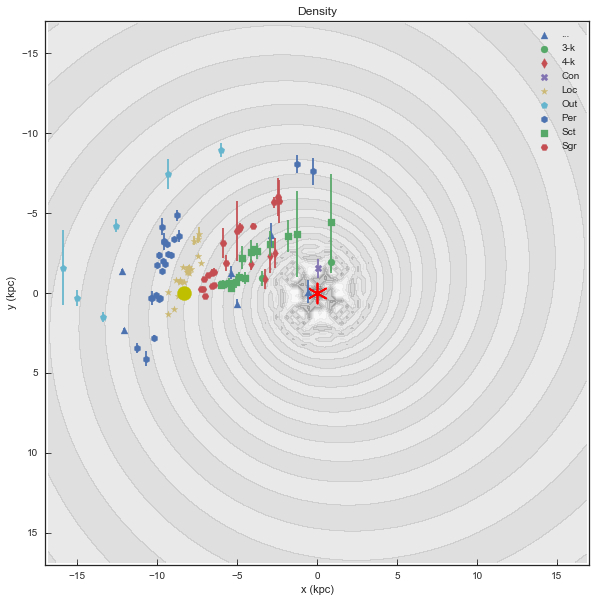

In [26]:
sp = SpiralArmsPotential(amp=1, N=4, alpha=alpha_avg*u.deg, phi_ref=phi_ref_avg*u.deg, r_ref=r_ref_avg*u.kpc,
                         H=0.18*u.kpc, Cs=[1])
plt_hmsfr_and_spirals(sp);